In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar10 as data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import BatchNormalization, Dropout
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.inspection import permutation_importance


In [2]:
#資料型態分布
#箱型圖
def box_graph(data_frame,name_list,name_pre):
    for i in range(len(name_list)):
        plt.figure(figsize=(2,5))
        plt.boxplot(data_frame[name_list[i]],showmeans=True)   
        plt.title(name_pre[i])
        plt.show()
        sns.histplot(data_frame[name_list[i]], kde=True)
        plt.show()
        print("偏態(Skewness): {:.2f}".format(data_frame[name_list[i]].skew()))
        print("峰度(Kurtosis): {:.2f}".format(data_frame[name_list[i]].kurt()))
        print('==================================================================================================')

#特徵關聯圖
def corr_matrix_graph(data_frame):
    corr_matrix = data_frame.corr()
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5,fmt='.2f') #各參數代表的意思請查閱seaborn.heatmap官網的說明
    plt.title(' Correlation ')
    plt.show()

In [3]:
#資料前處理
#name_list_outlier =['手機螢幕溫度(平均)','手機螢幕溫度(最大)','手機背蓋溫度(平均)','平均APP運作指標/小時','充電時間指標','手機電池電量','手機外殼/包膜指標','外型平均曲率','上網頻率指標','通話頻率指標','新機/二手/老舊','內容容量比率']
#name_pre_outlier = ['Mobile Screen Temperature (Average)','Mobile Screen Temperature (Max)','Mobile Phone Back Cover Temperature (Average)','Average APP Operation Index/Hour','Charging Time Index','Mobile Phone Battery Level','Mobile Phone Shell/Envelope Index','Average Curvature of Appearance','Internet Frequency Index','Call Frequency Index','New/Used/Old','Content Capacity Ratio','CPU Performance Rating']

#離群值處理
def  outlier_del(data_frame,name_list_outlier):
    for i, name in enumerate(name_list_outlier):
        print(name)
        print("Shape Of The Before Ouliers: ", data_frame[name].shape)
    
        # 计算IQR
        Q1 = np.percentile(data_frame[name], 25)
        Q3 = np.percentile(data_frame[name], 75)
        IQR = Q3 - Q1
        n = 1.5

        # 定义离群值范围
        lower_bound = Q1 - n * IQR
        upper_bound = Q3 + n * IQR

        # 过滤离群值
        filtered_entries = ((data_frame[name] >= lower_bound) & (data_frame[name] <= upper_bound))
        data_frame = data_frame[filtered_entries]
    
        print("Shape Of The After Ouliers: ",data_frame[name].shape)
        print('===================================================================================================================')
    return data_frame

#正規化
def data_normalized(data):
    min_max_scaler = MinMaxScaler()
    data_normalized = min_max_scaler.fit_transform(data)
    return data_normalized

#標準化
def data_standardized(data):
    standard_scaler = StandardScaler()
    data_standardized = standard_scaler.fit_transform(data)
    return data_standardized 


In [4]:
#分割資料集
from sklearn.model_selection import train_test_split
def data_split(x_data,y_data):
    Xtrain, Xtest, ytrain, ytest = train_test_split(x_data, y_data, test_size=0.1, random_state=1,stratify=y_data)
    return Xtrain, Xtest, ytrain, ytest


In [5]:
#submission.csv資料建立
def read_test():
    test=pd.read_excel("01test.xlsx")
    return test
def trans_ans(predicted_ans):
    predicted_classes = (predicted_ans > 0.4).astype(int)
    print(predicted_classes .shape)
    return predicted_classes

In [6]:
#data_train_way
#交叉驗證模型
def create_model(input_dim):
    l2_regularizer = tf.keras.regularizers.l2(0.01)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [7]:
#主程式
#read_data
data_frame_train=pd.read_excel("01train.xlsx")
data_frame_ays=pd.read_excel("data_anysis.xlsx")
data_frame_test=pd.read_excel("01test.xlsx")

data_frame_train.describe()


,手機螢幕溫度(平均),手機螢幕溫度(最大),手機背蓋溫度(平均),平均APP運作指標/小時,充電時間指標,手機電池電量,CPU跑分階級,手機外殼/包膜指標,外型平均曲率,上網頻率指標,通話頻率指標,新機/二手/老舊,內容容量比率,CPU效能等級,Underclocking
count,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000
mean,38.984541,45.294944,52.784871,656.507337,0.225864,75.190124,3.319754,0.109481,0.015342,2553.566565,2209.062206,0.297463,0.833713,1.319754,0.428132
std,14.540574,15.546263,64.786127,717.237752,0.232311,14.008806,0.684632,0.090865,0.125137,1829.663990,1810.428997,0.572666,12.506317,0.684632,0.494871
min,7.902370,8.047619,2.562656,-8000.000000,0.000000,47.889610,3.000000,0.003690,-1.043000,0.675070,0.000000,0.000000,-600.000000,1.000000,0.000000
25%,28.642857,34.880952,43.504429,224.700000,0.030303,62.761544,3.000000,0.058475,-0.055860,948.100000,579.800000,0.000000,0.802960,1.000000,0.000000
50%,38.976190,47.023810,53.053333,413.100000,0.142857,76.677489,3.000000,0.085307,0.005701,2276.000000,1898.000000,0.000000,0.937191,1.000000,0.000000
75%,50.119048,57.345238,60.650000,834.969651,0.371429,86.821260,3.000000,0.143723,0.078966,3839.552040,3455.073327,1.000000,0.987258,1.000000,1.000000
max,75.619048,79.547619,4000.000000,4412.000000,0.966667,100.000000,6.000000,1.776212,1.208233,8410.000000,8129.000000,5.000000,500.000000,4.000000,1.000000


In [8]:
#data arrange
#outlier
name_list_outlier =['手機螢幕溫度(平均)','手機螢幕溫度(最大)','手機背蓋溫度(平均)','平均APP運作指標/小時','充電時間指標','手機電池電量','手機外殼/包膜指標','外型平均曲率','上網頻率指標','通話頻率指標','內容容量比率']
name_pre_outlier = ['Mobile Screen Temperature (Average)','Mobile Screen Temperature (Max)','Mobile Phone Back Cover Temperature (Average)','Average APP Operation Index/Hour','Charging Time Index','Mobile Phone Battery Level','Mobile Phone Shell/Envelope Index','Average Curvature of Appearance','Internet Frequency Index','Call Frequency Index','New/Used/Old','Content Capacity Ratio','CPU Performance Rating']
data_frame_arrange=outlier_del(data_frame_train,name_list_outlier)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #z-scaler物件
columns_to_scale = ['手機螢幕溫度(平均)','手機螢幕溫度(最大)','手機背蓋溫度(平均)','平均APP運作指標/小時','充電時間指標','手機電池電量','上網頻率指標','通話頻率指標','內容容量比率']
data_frame_arrange[columns_to_scale] = scaler.fit_transform(data_frame_arrange[columns_to_scale])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns_to_normalize = [
    '手機螢幕溫度(平均)', '手機螢幕溫度(最大)', '手機背蓋溫度(平均)', '平均APP運作指標/小時', 
    '充電時間指標', '手機電池電量', '上網頻率指標', '通話頻率指標', '內容容量比率'
]
data_frame_arrange[columns_to_normalize] = scaler.fit_transform(data_frame_arrange[columns_to_normalize])

# 查看正规化后的统计描述


data_frame_arrange.describe()

手機螢幕溫度(平均)
Shape Of The Before Ouliers:  (3903,)
Shape Of The After Ouliers:  (3903,)
手機螢幕溫度(最大)
Shape Of The Before Ouliers:  (3903,)
Shape Of The After Ouliers:  (3903,)
手機背蓋溫度(平均)
Shape Of The Before Ouliers:  (3903,)
Shape Of The After Ouliers:  (3783,)
平均APP運作指標/小時
Shape Of The Before Ouliers:  (3783,)
Shape Of The After Ouliers:  (3528,)
充電時間指標
Shape Of The Before Ouliers:  (3528,)
Shape Of The After Ouliers:  (3504,)
手機電池電量
Shape Of The Before Ouliers:  (3504,)
Shape Of The After Ouliers:  (3504,)
手機外殼/包膜指標
Shape Of The Before Ouliers:  (3504,)
Shape Of The After Ouliers:  (3422,)
外型平均曲率
Shape Of The Before Ouliers:  (3422,)
Shape Of The After Ouliers:  (3312,)
上網頻率指標
Shape Of The Before Ouliers:  (3312,)
Shape Of The After Ouliers:  (3295,)
通話頻率指標
Shape Of The Before Ouliers:  (3295,)
Shape Of The After Ouliers:  (3292,)
內容容量比率
Shape Of The Before Ouliers:  (3292,)
Shape Of The After Ouliers:  (3085,)


,手機螢幕溫度(平均),手機螢幕溫度(最大),手機背蓋溫度(平均),平均APP運作指標/小時,充電時間指標,手機電池電量,CPU跑分階級,手機外殼/包膜指標,外型平均曲率,上網頻率指標,通話頻率指標,新機/二手/老舊,內容容量比率,CPU效能等級,Underclocking
count,3085.000000,3085.000000,3085.000000,3085.000000,3085.000000,3085.000000,3085.000000,3085.000000,3085.000000,3085.000000,3085.000000,3085.000000,3085.000000,3085.000000,3085.000000
mean,0.470148,0.529893,0.503965,0.308254,0.250137,0.521052,3.200972,0.101406,0.008485,0.334768,0.294682,0.320583,0.779948,1.200972,0.425284
std,0.204323,0.206340,0.176703,0.224287,0.256640,0.271710,0.524805,0.052472,0.098143,0.220130,0.224058,0.586252,0.249031,0.524805,0.494466
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.003690,-0.260300,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.320143,0.381440,0.387998,0.133165,0.030440,0.282451,3.000000,0.058575,-0.058010,0.150051,0.101781,0.000000,0.650529,1.000000,0.000000
50%,0.467149,0.543842,0.517357,0.240094,0.157669,0.537210,3.000000,0.085216,0.003822,0.306790,0.264328,0.000000,0.883850,1.000000,0.000000
75%,0.624833,0.690208,0.624820,0.430593,0.420588,0.772586,3.000000,0.141980,0.069451,0.493351,0.459303,1.000000,0.974153,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,0.269723,0.281614,1.000000,1.000000,5.000000,1.000000,4.000000,1.000000


C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from current font.
  fig.canvas.draw()
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 27231 (\N{CJK UNIFIED IDEOGRAPH-6A5F}) missing from current font.
  fig.canvas.draw()
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 34722 (\N{CJK UNIFIED IDEOGRAPH-87A2}) missing from current font.
  fig.canvas.draw()
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 24149 (\N{CJK UNIFIED IDEOGRAPH-5E55}) missing from current font.
  fig.canvas.draw()
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 28331 (\N{CJK UNIFIED IDEOGRAPH-6EAB}) missing from current font.
  fig.canvas.draw()
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\seaborn\utils.py:61: U

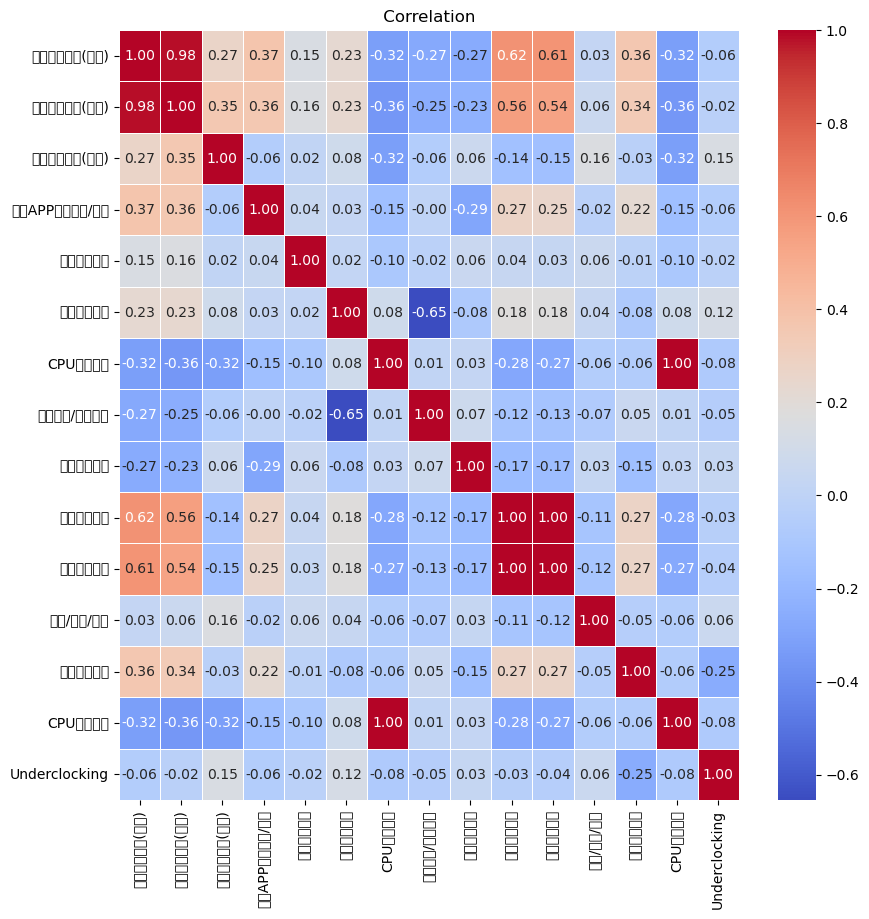

In [9]:
corr_matrix_graph(data_frame_arrange)

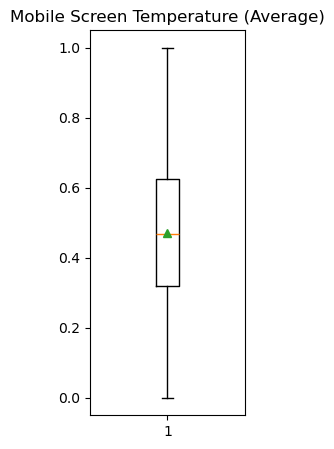

C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27231 (\N{CJK UNIFIED IDEOGRAPH-6A5F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 34722 (\N{CJK UNIFIED IDEOGRAPH-87A2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24149 (\N{CJK UNIFIED IDEOGRAPH-5E55}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28331 (\N{CJK UNIFIED I

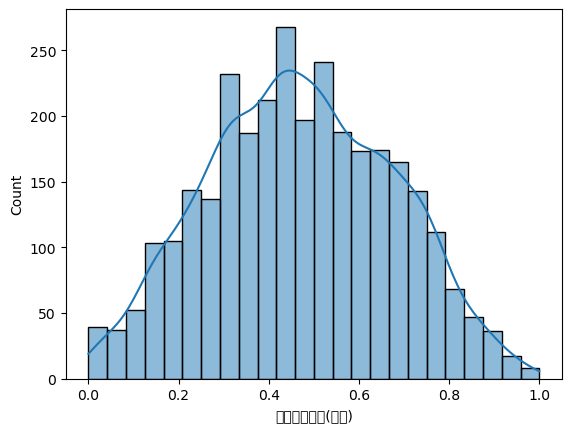

偏態(Skewness): 0.03
峰度(Kurtosis): -0.61


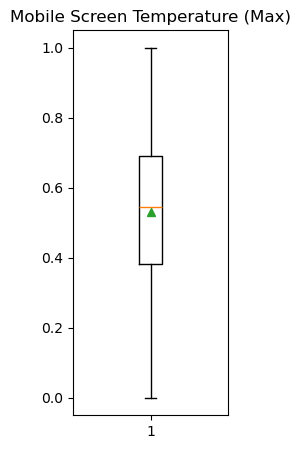

C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27231 (\N{CJK UNIFIED IDEOGRAPH-6A5F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 34722 (\N{CJK UNIFIED IDEOGRAPH-87A2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24149 (\N{CJK UNIFIED IDEOGRAPH-5E55}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28331 (\N{CJK UNIFIED I

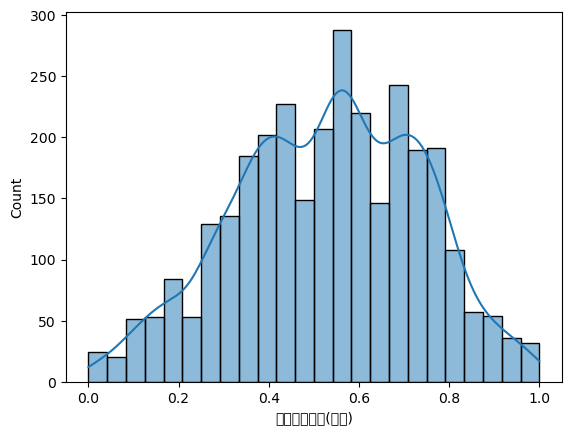

偏態(Skewness): -0.17
峰度(Kurtosis): -0.52


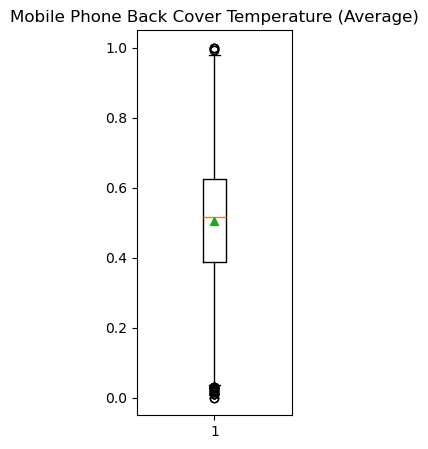

C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27231 (\N{CJK UNIFIED IDEOGRAPH-6A5F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32972 (\N{CJK UNIFIED IDEOGRAPH-80CC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33995 (\N{CJK UNIFIED IDEOGRAPH-84CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28331 (\N{CJK UNIFIED I

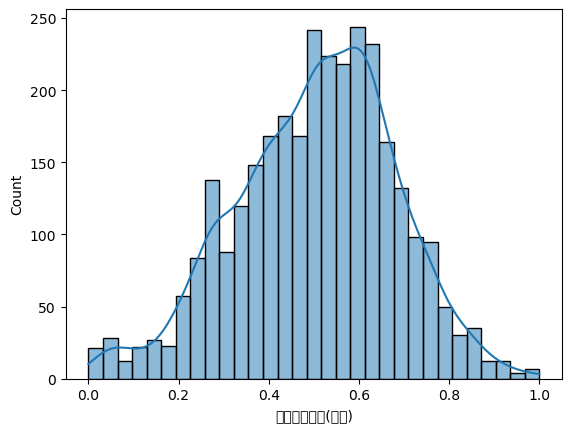

偏態(Skewness): -0.27
峰度(Kurtosis): -0.09


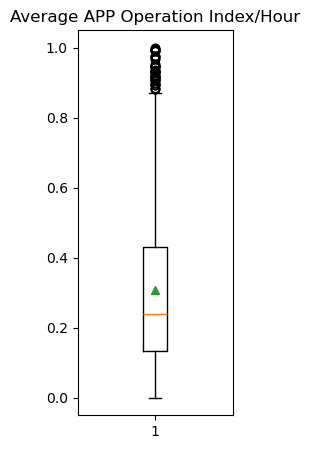

C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36939 (\N{CJK UNIFIED IDEOGRAPH-904B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25351 (\N{CJK UNIFIED I

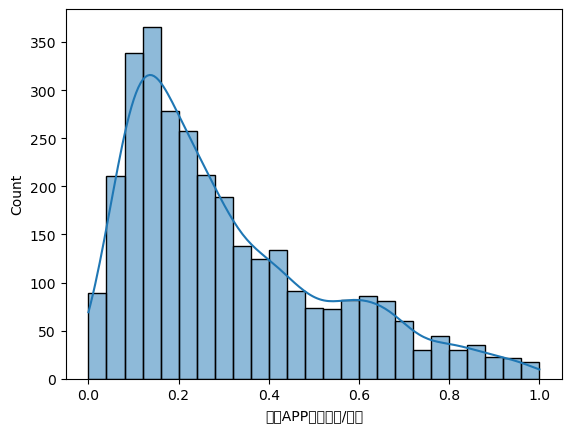

偏態(Skewness): 0.99
峰度(Kurtosis): 0.20


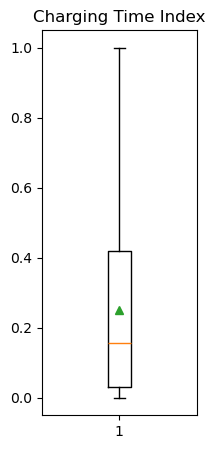

C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20805 (\N{CJK UNIFIED IDEOGRAPH-5145}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38651 (\N{CJK UNIFIED IDEOGRAPH-96FB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25351 (\N{CJK UNIFIED I

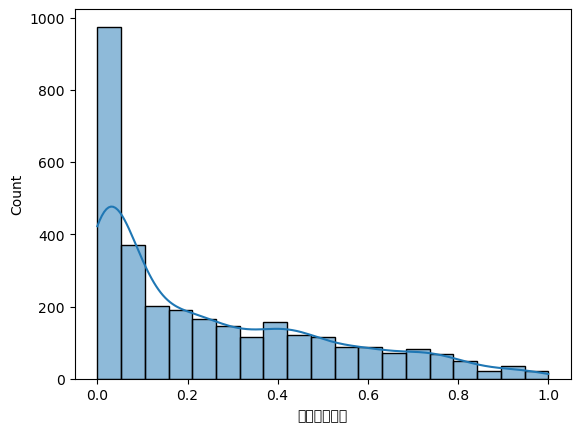

偏態(Skewness): 0.95
峰度(Kurtosis): -0.14


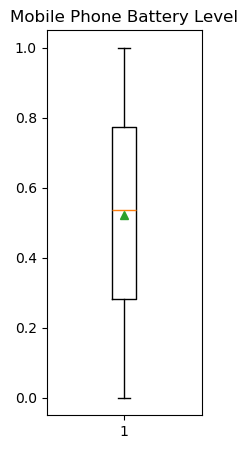

C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27231 (\N{CJK UNIFIED IDEOGRAPH-6A5F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38651 (\N{CJK UNIFIED IDEOGRAPH-96FB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27744 (\N{CJK UNIFIED IDEOGRAPH-6C60}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED I

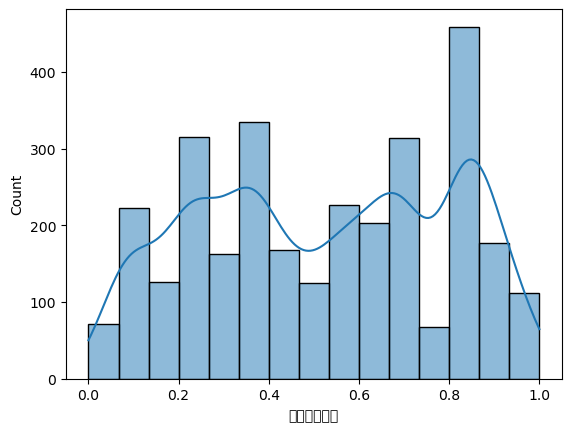

偏態(Skewness): -0.06
峰度(Kurtosis): -1.26


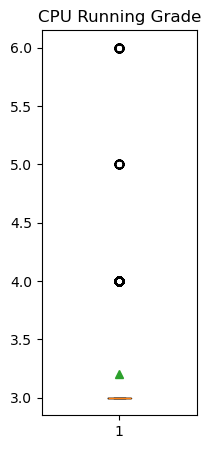

C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36305 (\N{CJK UNIFIED IDEOGRAPH-8DD1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38542 (\N{CJK UNIFIED IDEOGRAPH-968E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32026 (\N{CJK UNIFIED IDEOGRAPH-7D1A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


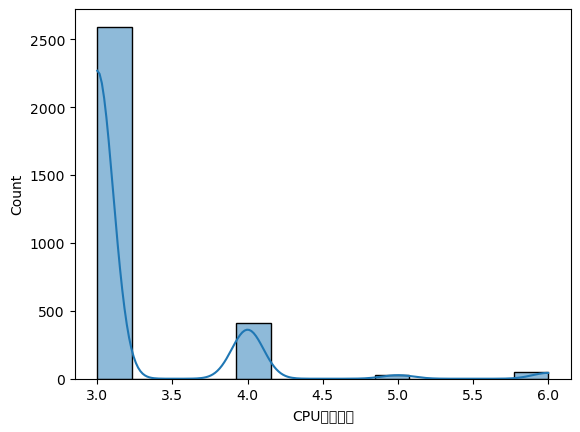

偏態(Skewness): 3.23
峰度(Kurtosis): 11.96


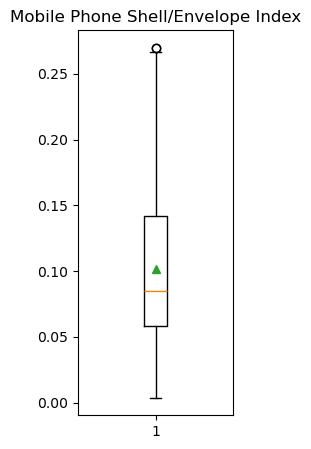

C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27231 (\N{CJK UNIFIED IDEOGRAPH-6A5F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27580 (\N{CJK UNIFIED IDEOGRAPH-6BBC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21253 (\N{CJK UNIFIED I

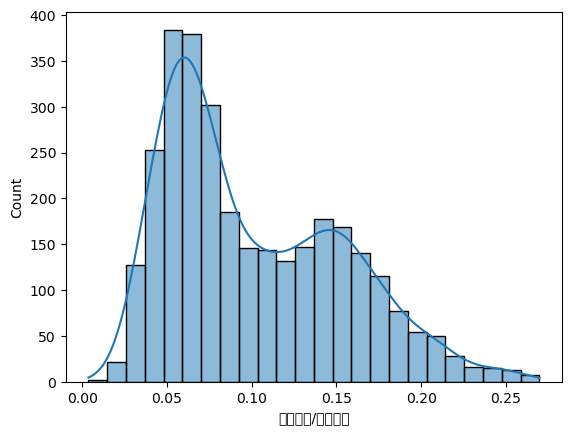

偏態(Skewness): 0.69
峰度(Kurtosis): -0.40


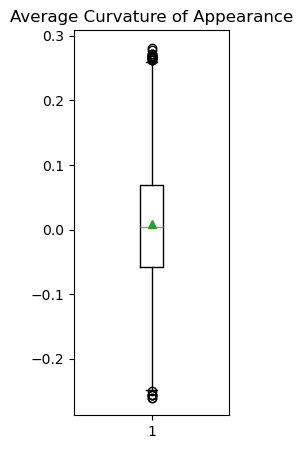

C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26354 (\N{CJK UNIFIED I

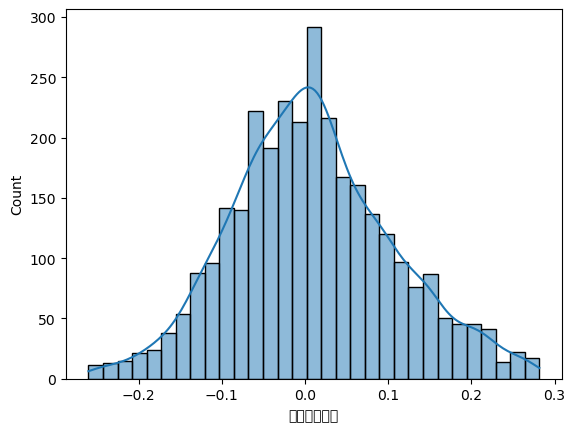

偏態(Skewness): 0.21
峰度(Kurtosis): -0.02


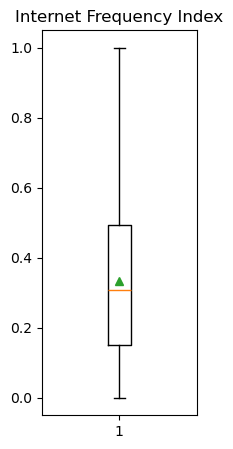

C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32178 (\N{CJK UNIFIED IDEOGRAPH-7DB2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25351 (\N{CJK UNIFIED I

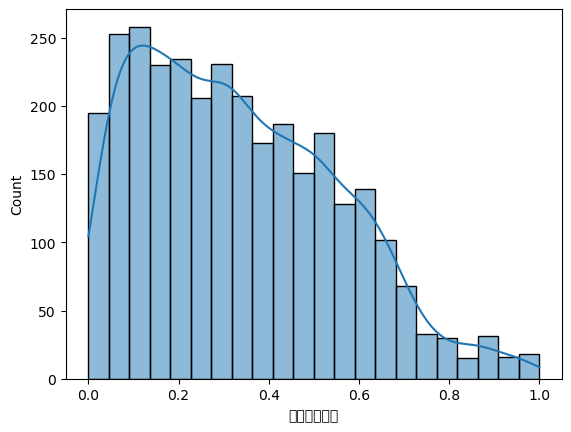

偏態(Skewness): 0.55
峰度(Kurtosis): -0.38


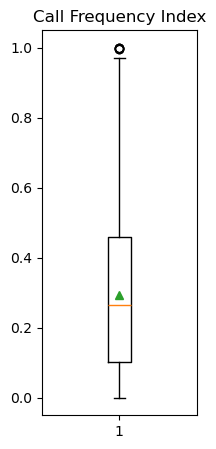

C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35441 (\N{CJK UNIFIED IDEOGRAPH-8A71}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25351 (\N{CJK UNIFIED I

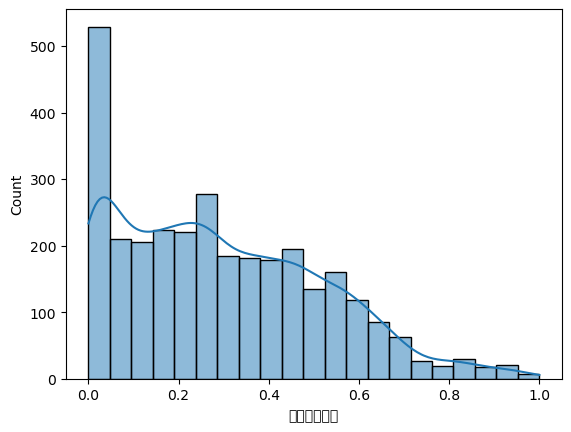

偏態(Skewness): 0.57
峰度(Kurtosis): -0.37


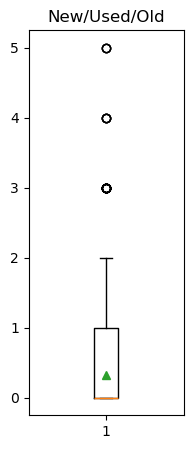

C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27231 (\N{CJK UNIFIED IDEOGRAPH-6A5F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32769 (\N{CJK UNIFIED I

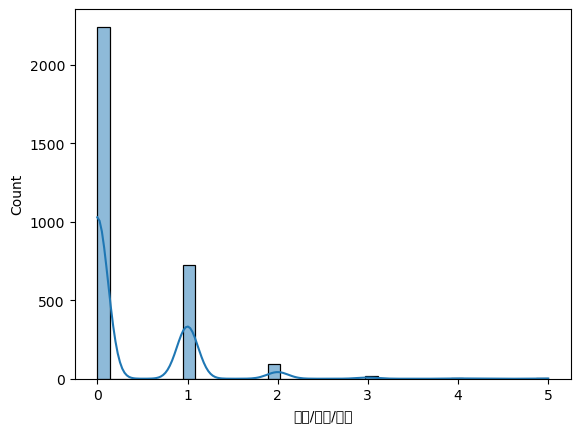

偏態(Skewness): 2.26
峰度(Kurtosis): 7.74


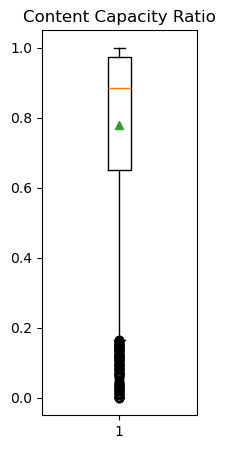

C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20839 (\N{CJK UNIFIED IDEOGRAPH-5167}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23481 (\N{CJK UNIFIED IDEOGRAPH-5BB9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED I

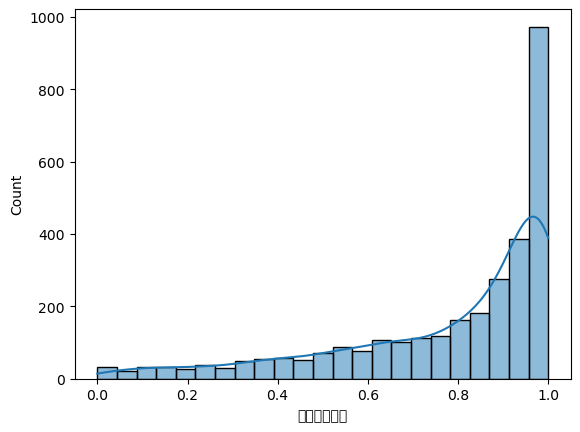

偏態(Skewness): -1.29
峰度(Kurtosis): 0.76


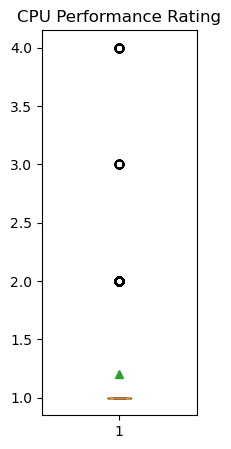

C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25928 (\N{CJK UNIFIED IDEOGRAPH-6548}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerom\anaconda3\envs\110810042\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32026 (\N{CJK UNIFIED IDEOGRAPH-7D1A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


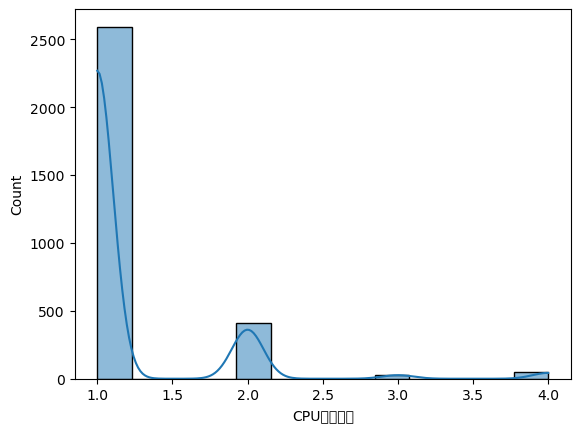

偏態(Skewness): 3.23
峰度(Kurtosis): 11.96


In [10]:
name_list=['手機螢幕溫度(平均)','手機螢幕溫度(最大)','手機背蓋溫度(平均)','平均APP運作指標/小時','充電時間指標','手機電池電量','CPU跑分階級','手機外殼/包膜指標','外型平均曲率','上網頻率指標','通話頻率指標','新機/二手/老舊','內容容量比率','CPU效能等級',]
name_pre=['Mobile Screen Temperature (Average)','Mobile Screen Temperature (Max)','Mobile Phone Back Cover Temperature (Average)','Average APP Operation Index/Hour','Charging Time Index','Mobile Phone Battery Level','CPU Running Grade','Mobile Phone Shell/Envelope Index','Average Curvature of Appearance','Internet Frequency Index','Call Frequency Index','New/Used/Old','Content Capacity Ratio','CPU Performance Rating']
box_graph(data_frame_arrange,name_list,name_pre)

In [11]:
#分割
y_data = data_frame_arrange['Underclocking'].to_numpy()
#feature_ex=['手機螢幕溫度(平均)','手機螢幕溫度(最大)','手機背蓋溫度(平均)','平均APP運作指標/小時','充電時間指標','手機電池電量','手機外殼/包膜指標','外型平均曲率','上網頻率指標','通話頻率指標','內容容量比率']
feature_ex = ['手機背蓋溫度(平均)','平均APP運作指標/小時','手機電池電量','CPU跑分階級','新機/二手/老舊','內容容量比率']
x_data = data_frame_arrange[feature_ex].to_numpy()
Xtrain, Xtest, ytrain, ytest=data_split(x_data,y_data)

#data arrange
#正規化


Xtrain, Xtest, ytrain, ytest=data_split(x_data,y_data)
print("Xtrain shape:", Xtrain.shape)
print("Xtrain type:", type(Xtrain))
print("Xtest shape:", Xtest.shape)
print("Xtest type:", type(Xtest))
print("ytrain shape:", ytrain.shape)
print("ytrain type:", type(ytrain))
print("ytest shape:", ytest.shape)
print("ytest type:", type(ytest))



Xtrain shape: (2776, 6)
Xtrain type: <class 'numpy.ndarray'>
Xtest shape: (309, 6)
Xtest type: <class 'numpy.ndarray'>
ytrain shape: (2776,)
ytrain type: <class 'numpy.ndarray'>
ytest shape: (309,)
ytest type: <class 'numpy.ndarray'>


In [12]:
l2_regularizer = tf.keras.regularizers.l2(0.01)
input_features = x_data.shape[1]
print( x_data.shape[1])
model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_features,)),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105 (420.00 B)

 Trainable params: 105 (420.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(Xtrain, ytrain, batch_size=32, epochs=100,validation_split=0.1 ) #default batch=32
print(history.history.keys())


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5554 - loss: 0.6883 - val_accuracy: 0.6151 - val_loss: 0.6675
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.5638 - loss: 0.6861 - val_accuracy: 0.6151 - val_loss: 0.6669
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.5802 - loss: 0.6820 - val_accuracy: 0.6151 - val_loss: 0.6769
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - accuracy: 0.5715 - loss: 0.6849 - val_accuracy: 0.6151 - val_loss: 0.6688
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.5606 - loss: 0.6871 - val_accuracy: 0.6151 - val_loss: 0.6706
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.5659 - loss: 0.6864 - val_accuracy: 0.6151 - val_loss: 0.6724
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.5786 - loss: 0.6821 - val_accuracy: 0.6151 - val_loss: 0.6713
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.5560 - loss: 0.6877 - val_accura

In [14]:
class KerasClassifierWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)

    def score(self, X, y, **kwargs):
        # 计算精确度时，我们将概率转换为类别标签
        y_pred = self.predict(X)  # 使用下面定义的 predict 方法
        return accuracy_score(y, y_pred)

    def predict(self, X, **kwargs):
        # 获取预测概率
        probabilities = self.model.predict(X, **kwargs)
        # 应用阈值转换概率为类别标签
        return (probabilities > 0.5).astype(int)

model_wrapper = KerasClassifierWrapper(model)
result = permutation_importance(
    model_wrapper, Xtrain, ytrain, 
    n_repeats=10,  # 置换次数
    random_state=42, 
    scoring='accuracy'
)

importances = result.importances_mean  # 获取平均重要性评分
# 假设 Xtrain 是一个 DataFrame 或者你有一个特征名称的列表
feature_names =['手機背蓋溫度(平均)','平均APP運作指標/小時','手機電池電量','CPU跑分階級','新機/二手/老舊','內容容量比率']

# 输出每个特征的重要性
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {importances[i]}")


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
87/87 ━━━━━━━━━━

In [15]:
results = model.evaluate(Xtest, ytest)
print('Final test set loss: {:4f}'.format(results[0]))
print('Final test set accuracy: {:4f}'.format(results[1]))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.5681 - loss: 0.6839
Final test set loss: 0.681621
Final test set accuracy: 0.576052


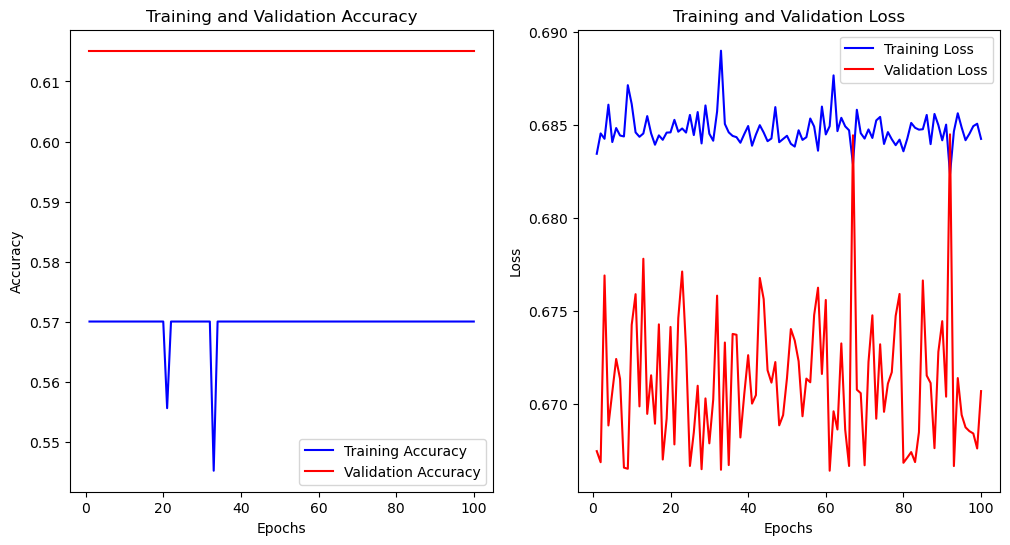

In [16]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_ = range(1,len(acc)+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_, acc, 'b-', label='Training Accuracy')
plt.plot(epochs_, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_, loss, 'b-', label='Training Loss')
plt.plot(epochs_, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()